In [233]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

In [234]:
dataset_path = r"C:\Users\Jazlyn\Semester 4\Research\AI Model\Data\BBCA\bbca_10yStock.csv"

In [235]:
df = pd.read_csv(dataset_path, delimiter=',' )
df.pop("Open")
df.pop("High")
df.pop("Low")
df.pop("Volume")

df.head()


,Date,Close
0,13-05-15,2268.215576
1,15-05-15,2235.163574
2,18-05-15,2247.557861
3,19-05-15,2255.820801
4,20-05-15,2293.004883


In [236]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2465 entries, 0 to 2464
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2465 non-null   object 
 1   Close   2465 non-null   float64
dtypes: float64(1), object(1)
memory usage: 38.6+ KB


In [237]:
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2465 entries, 0 to 2464
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2465 non-null   datetime64[ns]
 1   Close   2465 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 38.6 KB


C:\Users\Jazlyn\AppData\Local\Temp\ipykernel_3708\2332167108.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)


In [238]:
# Set 'date' column as index
df.set_index('Date', inplace=True)

df.head()

,Close
Date,
2015-05-13,2268.215576
2015-05-15,2235.163574
2015-05-18,2247.557861
2015-05-19,2255.820801
2015-05-20,2293.004883


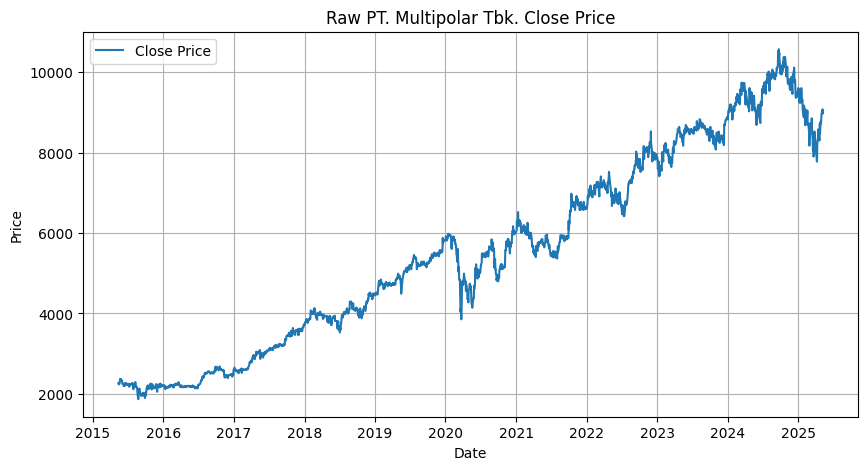

In [239]:
# Plot raw prices
plt.figure(figsize=(10, 5))
plt.plot(df['Close'], label='Close Price')
plt.title("Raw PT. Multipolar Tbk. Close Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.grid()
plt.legend()
plt.show()

In [240]:
# 2. Preprocessing
def preprocess_data(df, sequence_length=60):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)

    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])
        y.append(scaled_data[i])

    X, y = np.array(X), np.array(y)
    return X, y, scaler


In [241]:
# 3. Build CNN-LSTM Model
def build_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])
    return model

In [242]:
X, y, scaler = preprocess_data(df)  # Melakukan preprocessing

In [243]:
model_path = 'cnn_lstm_best_model.keras'

callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True),
    ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss'),
    CSVLogger('CNN-LSTM_BBCA.csv', append=False)
]

In [244]:

# 4. Train and Evaluate
def train_and_evaluate(X, y):
    split = int(0.8 * len(X))  # 80% train, 20% test
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model = build_model(X_train.shape[1:])

    history = model.fit(
        X_train, y_train, 
        epochs=50, 
        batch_size=32, 
        validation_data=(X_test, y_test), 
        callbacks=callbacks)

    model = load_model(model_path)
    preds = model.predict(X_test)

    y_test_inv = scaler.inverse_transform(y_test)
    y_pred_inv = scaler.inverse_transform(preds)

    mae = mean_absolute_error(y_test, preds)
    # rmse = mean_squared_error(y_test, preds, squared=False)
    mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv) * 100
    mse = mean_squared_error(y_test, preds)

    print(f"MAE: {mae:.10f}")
    print(f"MSE: {mse:.10f}")
    # print(f"RMSE: {rmse:.5f}")
    print(f"MAPE: {mape:.10f}%")

    # Optional: plot
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='True')
    plt.plot(preds, label='Predicted')
    plt.legend()
    plt.title('Prediction vs True BBCA')
    plt.show()

    # ---------------------- Plot Prediction vs Actual ----------------------
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train mse')
    plt.plot(history.history['mae'], label='train mae')
    plt.plot(history.history['val_loss'], label='test mse')
    plt.plot(history.history['val_mae'], label='test mae')

    plt.title("Training Log Plot BBCA")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch 1/50


c:\Users\Jazlyn\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0445 - mae: 0.1396 - mse: 0.0445 - val_loss: 0.0019 - val_mae: 0.0361 - val_mse: 0.0019
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.2397e-04 - mae: 0.0150 - mse: 4.2397e-04 - val_loss: 0.0010 - val_mae: 0.0252 - val_mse: 0.0010
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.8645e-04 - mae: 0.0135 - mse: 3.8645e-04 - val_loss: 6.8370e-04 - val_mae: 0.0207 - val_mse: 6.8370e-04
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.9286e-04 - mae: 0.0137 - mse: 3.9286e-04 - val_loss: 6.3709e-04 - val_mae: 0.0197 - val_mse: 6.3709e-04
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.6749e-04 - mae: 0.0131 - mse: 3.6749e-04 - val_loss: 6.5214e-04 - val_mae: 0.0199 - val_mse: 6.5214e-04
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.2057e-04 - mae: 0.0120 - mse: 3.2057e-04 - val_loss: 6.4553e-04 - val_mae: 0.0200 - val_mse: 6.4553e-04
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

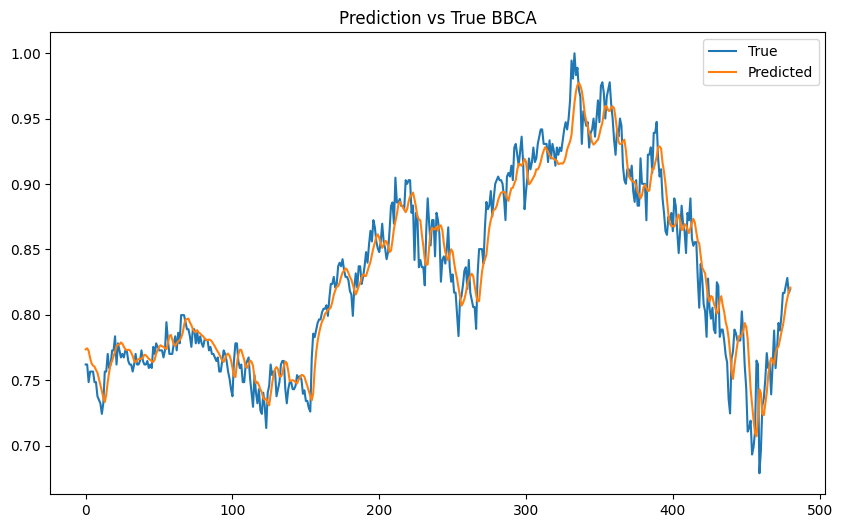

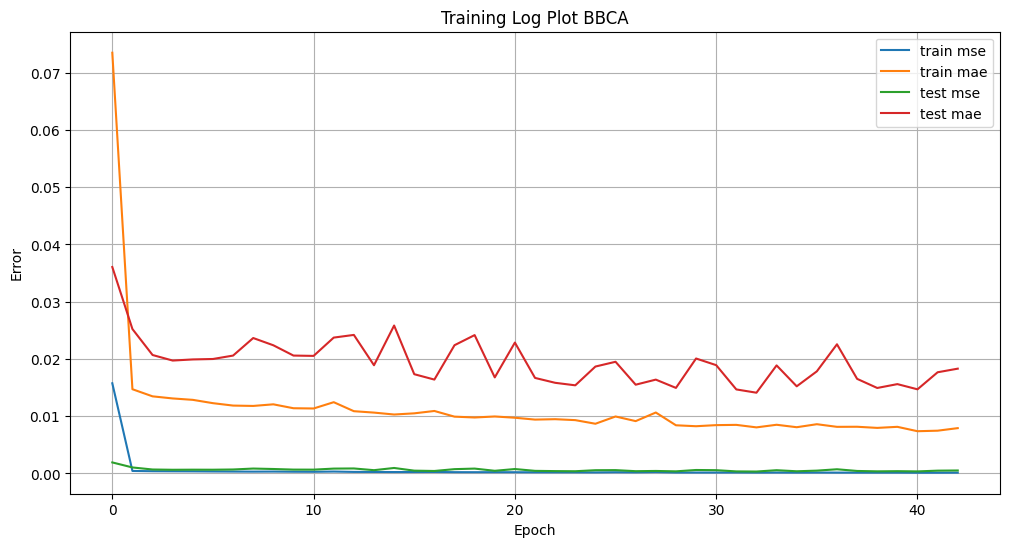

In [245]:
train_and_evaluate(X, y)  # Melatih dan mengevaluasi model